# Basic multi-layer perceptron for classifying MNIST

In this implementation I changed a few things from the network. I 
added ReLU and SoftMax activation (and a cross entropy loss) to respectively hidden and last layers. I also added L2 Regularization and Dropout.
More recently, I migrated the code from python 2 to python 3

This code was what lead to the implementation of the GAN with numpy exclusively

In [34]:
import random
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

## Data loader

In [2]:
#Data loader and wrapper by "mnielsen" https://github.com/mnielsen/neural-networks-and-deep-learning
def load_data():
    '''Loading the mnist dataset from an archive'''
    f = gzip.open('./mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    '''Reshaping the data in a tuple with on one hand the greyscale image and on the other the the label (between 0-9)'''
    tr_d, va_d, te_d = load_data()
    
    #Organizing the training set
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    
    #Organizing the validation set
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    
    #Organizing the testing set 
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    '''Vectorizing the output with 1 at the true label and zeroes everywhere else'''
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
#Loading data
training_data, validation_data, test_data = load_data_wrapper()

## Implementation of the Network

In [20]:
#Network inspired by "mnielsen" https://github.com/mnielsen/neural-networks-and-deep-learning
#In this implementation I changed a few things from the network
#Added ReLU and SoftMax activation to respectively hidden and last layers
#Added L2 Regularization and Dropout
#Migrated the code from python 2 to python 3
class Network(object):
    def __init__(self, sizes,p=0.5):
        '''For initialization, sizes is the list of sizes of the layers [input h1 h2 h3 ... hn]
        the output is always be 10 and should not be specified
        p is dropout rate'''
        #Initialization 
        #picking a random seed
        np.random.seed(0)
        #avoiding conditionning error in adagrad
        self.eps = np.finfo(np.float).eps
        #storing hyper parameters as attributes
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.p = p
        
        self.dropOut = [np.random.binomial(1, p, size = y) for y in self.sizes[1:]]
        
        #Initializing weights with low variance gaussians
        #Initializing biases with 0
        self.biases = [np.zeros([y, 1]) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)/5.0
                        for x, y in list(zip(sizes[:-1], sizes[1:]))]

        #Initialization of the softmax layer
        self.weightsSoftMax = np.random.randn(10, sizes[-1])/5.0
        self.biasSoftMax = np.zeros([10,1])
        
        #Initialization of loss lists for plotting
        self.test_lost=[]
        self.test_accuracy=[]
    
    def feedforward(self, a):
        '''This function computes the forward pass with dropout'''
        for b, w, dp in list(zip(self.biases, self.weights, self.dropOut)):
            #ReLU activation
            a = ReLU(np.dot(w, a)+b)
        #last layer has a softmax activation
        a = softmax(np.dot(self.weightsSoftMax,a)+self.biasSoftMax)
        return a 
    
    def feedforwardNoDrop(self, a):
        '''This function can be used to compute the forward pass with dropout. Since this function does not
        store intermediate states, it is not used in practice'''
        index=0
        for b, w in list(zip(self.biases, self.weights)):
            if index == 0:
                a = ReLU(np.dot(w, a)+b)
                index =1
            else:
                a = ReLU((np.dot(w, a)+ b) )*(self.p)
        a = softmax(np.dot(self.weightsSoftMax,a)+self.biasSoftMax)
        return a 
    
       
    def SGD(self, training_data, epochs, mini_batch_size, eta, regularization,
            test_data=None):
        '''Contains the loops over epoch and mini-batches and starts up the Stochastic Gradient Descent Algorithm
        No updtae is computed here though'''
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                #New dropout layer for each mini_batch
                self.dropOut = [np.array((np.random.rand(y, 1)<self.p),np.float) for y in self.sizes[1:]]
                self.update_mini_batch(mini_batch, eta, regularization)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta, regularization):
        '''The updates to weights and biases are done here, the update is done using the basic SGD algorithm'''
        #storing updates for weights and bias that have a ReLU activation
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        #storage for weights and biases that correspond to softmax layer
        nabla_b_SM = np.zeros_like(self.biasSoftMax)
        nabla_w_SM = np.zeros_like(self.weightsSoftMax)
        for x, y in mini_batch:
            #backprop for element in the mini_batch
            delta_nabla_b, delta_nabla_w, delta_b_SM, delta_w_SM = self.backprop(x, y)
            #incrementing the lists with updates
            nabla_b = [nb+dnb for nb, dnb in list(zip(nabla_b, delta_nabla_b))]
            nabla_w = [nw+dnw for nw, dnw in list(zip(nabla_w, delta_nabla_w))]
            nabla_b_SM = nabla_b_SM + delta_b_SM
            nabla_w_SM = nabla_w_SM + delta_w_SM
        
        #updating the weights and biaises of ReLU layers
        #the value of the update is average over all the elements of the mini_batch
        #addition of a regularization term
        self.weights = [w*(1-regularization*eta/len(w))-(eta/len(mini_batch))*nw 
                        for w, nw in list(zip(self.weights, nabla_w))]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in list(zip(self.biases, nabla_b))]
        
        #updating the weights and biaises of the softmax layer
        self.weightsSoftMax = self.weightsSoftMax*(1-eta*regularization/len(nabla_w)) - (eta/len(mini_batch))*nabla_w_SM 
        self.biasSoftMax -= (eta/len(mini_batch))*nabla_b_SM

    def backprop(self, x, y):
        '''This function computes the backpropagation to obtain gradients necessery to update the weights'''
        #intializing updates
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_bSM = np.zeros_like(self.biasSoftMax)
        nabla_wSM = np.zeros_like(self.weightsSoftMax)
        
        #FORWARD PASS
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs=[]
        index=0
        for b, w in list(zip(self.biases, self.weights)):
            #loop over ReLU lauyers
            #storing the z vector (output of layers before activation)
            z = (np.dot(w, activation)+b)
            zs.append(z)
            #storing activations as well
            #applying dropout to the activation of hidden layers
            activation = ReLU(z)*self.dropOut[index]
            activations.append(activation)
            index += 1
        
        #Storing z and activation for the softmax layer as well
        z = (np.dot(self.weightsSoftMax, activation)+self.biasSoftMax)
        zs.append(z)
        activation = softmax(z)
        activations.append(activation)
        
        #BACKWARD PASS
        #derivative of the loss fuction and the backpropagate the error through layers
        #dL/do = o - y
        delta = self.cost_derivative(activations[-1],y)
        #updates for the softmax layer
        nabla_bSM = delta
        nabla_wSM = np.dot(delta, activations[-2].transpose())
        #k-1 layer
        delta = np.dot(self.weightsSoftMax.transpose(), delta) * ReLU_prime(zs[-2])* self.dropOut[-1]
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-3].transpose())
        for l in range(2, self.num_layers):
            #k-l layer
            delta = np.dot(self.weights[-l+1].transpose(), delta) * ReLU_prime(zs[-l-1])* self.dropOut[-l]
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-2].transpose())
        #return the updates for the weights and biases
        return (nabla_b, nabla_w, nabla_bSM, nabla_wSM)

    def evaluate(self, test_data):
        ''''Evaluation of the network while shutting down dropout''''
        test_results = [(np.argmax(self.feedforwardNoDrop(x)), y)
                        for (x, y) in test_data]
        self.test_accuracy.append(sum(int(x == y) for (x, y) in test_results))
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        ''''derivative of the cross entropy loss when using a softmax layer'''
        return (output_activations - y)
    
#### Miscellaneous functions
def ReLU(z):
    '''ReLU activation fuction, x for x>0 and 0 if x <= 0'''
    a= np.copy(z)
    a[z<=0] = 0
    return a

def ReLU_prime(z):
    '''Derivative of ReLU activation fuction, 1 for x>0 and 0 if x <= 0'''
    a= np.zeros_like(z)
    a[z>0] = 1
    return a

def softmax(x):
    '''Computes softmax to get the output as a probability measure
    No need to create a softmax_prime because by using a cross entropy loss, the derivative of the layer is just
    the difference between true labels and computed labels'''
    exps = np.exp(x - x.max())
    return exps / np.sum(exps)

## Test various regularization methods

In [30]:
#Test with dropout, droping 30% of the connections

#Network parameters are sizes of [Input, hiddenlayer1, hiddenlayer2], p is dropout rate (of not dropped connections)
Net=Network([784,50,30],p=0.7)
#Training parameters are 
#1st argument is training dataset
#2nd argument is number of epochs
#3rd argument is mini batch size
#4th argument is learning rate
#5th argument is strength of L2 regularization (0 here since we are only testing dropout)
#6th argument is optional and is testing dataset, if none it will print training loss
Net.SGD(training_data,20,10,0.1,0.0,test_data=test_data)

Epoch 0: 9237 / 10000
Epoch 1: 9326 / 10000
Epoch 2: 9453 / 10000
Epoch 3: 9495 / 10000
Epoch 4: 9522 / 10000
Epoch 5: 9531 / 10000
Epoch 6: 9506 / 10000
Epoch 7: 9573 / 10000
Epoch 8: 9542 / 10000
Epoch 9: 9572 / 10000
Epoch 10: 9574 / 10000
Epoch 11: 9584 / 10000
Epoch 12: 9596 / 10000
Epoch 13: 9611 / 10000
Epoch 14: 9602 / 10000
Epoch 15: 9626 / 10000
Epoch 16: 9624 / 10000
Epoch 17: 9588 / 10000
Epoch 18: 9586 / 10000
Epoch 19: 9624 / 10000


In [31]:
#Test with L2 regularization (lambda = 0.05)

#Network parameters are sizes of [Input, hiddenlayer1, hiddenlayer2], p is dropout rate (here no dropout)
Net2=Network([784,50,30],p=1)
#Training parameters are 
#1st argument is training dataset
#2nd argument is number of epochs
#3rd argument is mini batch size
#4th argument is learning rate
#5th argument is strength of L2 regularization (0.05 here)
#6th argument is optional and is testing dataset, if none it will print training loss
Net2.SGD(training_data,20,10,0.1,0.05,test_data=test_data)

Epoch 0: 9404 / 10000
Epoch 1: 9508 / 10000
Epoch 2: 9443 / 10000
Epoch 3: 9475 / 10000
Epoch 4: 9593 / 10000
Epoch 5: 9628 / 10000
Epoch 6: 9470 / 10000
Epoch 7: 9543 / 10000
Epoch 8: 9505 / 10000
Epoch 9: 9612 / 10000
Epoch 10: 9609 / 10000
Epoch 11: 9602 / 10000
Epoch 12: 9627 / 10000
Epoch 13: 9692 / 10000
Epoch 14: 9702 / 10000
Epoch 15: 9687 / 10000
Epoch 16: 9605 / 10000
Epoch 17: 9691 / 10000
Epoch 18: 9627 / 10000
Epoch 19: 9654 / 10000


In [32]:
#Test with no regularization

#Network parameters are sizes of [Input, hiddenlayer1, hiddenlayer2], p is dropout rate (here no dropout)
Net3=Network([784,50,30],p=1)
#Training parameters are 
#1st argument is training dataset
#2nd argument is number of epochs
#3rd argument is mini batch size
#4th argument is learning rate
#5th argument is strength of L2 regularization (0 here because we are training with no regularization what so ever)
#6th argument is optional and is testing dataset, if none it will print training loss
Net3.SGD(training_data,20,10,0.1,0.0,test_data=test_data)

Epoch 0: 9379 / 10000
Epoch 1: 9544 / 10000
Epoch 2: 9574 / 10000
Epoch 3: 9577 / 10000
Epoch 4: 9659 / 10000
Epoch 5: 9636 / 10000
Epoch 6: 9683 / 10000
Epoch 7: 9679 / 10000
Epoch 8: 9619 / 10000
Epoch 9: 9638 / 10000
Epoch 10: 9640 / 10000
Epoch 11: 9634 / 10000
Epoch 12: 9640 / 10000
Epoch 13: 9661 / 10000
Epoch 14: 9641 / 10000
Epoch 15: 9541 / 10000
Epoch 16: 9683 / 10000
Epoch 17: 9684 / 10000
Epoch 18: 9667 / 10000
Epoch 19: 9638 / 10000


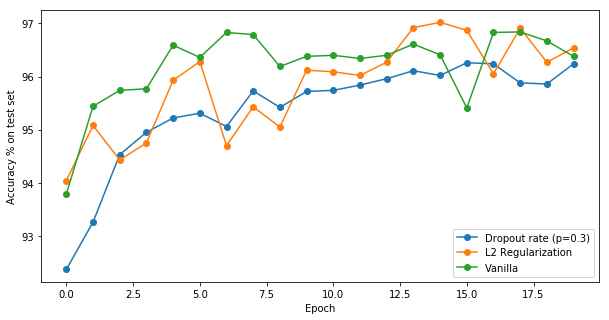

In [35]:
plt.plot(np.array(Net.test_accuracy)*(1/100.0),'o-',label='Dropout rate (p=0.3)')
plt.plot(np.array(Net2.test_accuracy)*(1/100.0),'o-',label='L2 Regularization')
plt.plot(np.array(Net3.test_accuracy)*(1/100.0),'o-',label='Vanilla')

plt.xlabel('Epoch')
plt.ylabel('Accuracy % on test set')
plt.legend()
plt.savefig('regularization.png',dpi=300)
plt.show()